<a href="https://colab.research.google.com/github/com0040/Super_Resolution_study/blob/main/Super_Resolution_SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow를 사용한 Super-Resolution 

---


> TensorFlow에서 이미지 초해상도 기술 구현.

- toc(목차): false
- badges(배지): true
- comments(댓글): true
- author(작성자): dzlab
- categories(카테고리): [tensorflow, generative, artistic]

단일 이미지 초해상도(SR)는 저해상도 이미지에서 고해상도 이미지를 복원하는 고전적인 컴퓨터 비전 문제입니다. 이 분야에서 광범위한 연구가 진행되어 딥러닝의 발전과 함께 매우 좋은 결과가 달성되었습니다.

이번 글에서는 초해상도 기술 중 하나인 [Super-Resolution Convolutional Neural Network (SRCNN)](https://arxiv.org/abs/1501.00092.)에 대해 살펴보겠습니다. 이 기술은 저해상도 이미지에서 패치를 추출하고 컨볼루션 레이어를 통해 고해상도 출력 픽셀로 매핑하는 방식으로 end-to-end로 작동합니다.

아래 그림에서 보듯이, 우리는 TensorFlow를 사용하여 SRCNN 모델을 구현하고 훈련한 다음, 저해상도 이미지에서 테스트해보겠습니다.

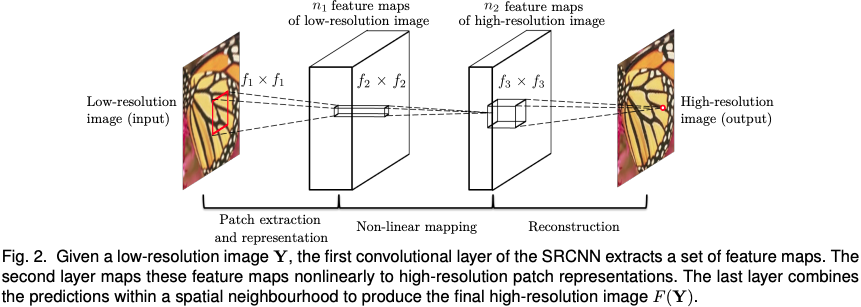

모델 훈련을 위해 Kaggle에서 제공하는 [Dog and Cat Detection](https://www.kaggle.com/andrewmvd/dog-and-cat-detection) 데이터셋을 사용하겠습니다. 이 데이터셋을 다운로드하기 위해 Kaggle CLI를 사용할 것이며, Kaggle API 키를 가져오거 웹사이트에서 직접 데이터셋을 수동으로 다운로드할 수도 있습니다.

In [ ]:
%%capture
%%bash

pip install -q kaggle

mkdir -p ~/.kaggle
echo '{"username":"lionlamb","key":"d2b59325e0dc84679377cc1a5a235efe"}' > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
%%bash

kaggle datasets download andrewmvd/dog-and-cat-detection
unzip -q dog-and-cat-detection.zip

모델 체크포인트와 기타 아티팩트를 저장하기 위해, 우리는 구글 드라이브를 이 colab 컨테이너에 마운트하겠습니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


종속성 가져오기

In [ ]:
import os
import pathlib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *

재현성을 위해 랜덤 시드 설정하기

In [ ]:
SEED = 31
np.random.seed(SEED)

## 데이터

스케일 요소를 기반으로 이미지 크기를 조정하는 함수가 필요합니다. 이 함수는 이후 과정에서 주어진 이미지로부터 저해상도 이미지를 생성하는 데 사용됩니다.

In [ ]:
def resize_image(image_array, factor):
    original_image = Image.fromarray(image_array)
    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)
    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resized = resized.astype(np.uint8)
    return resized

이 함수는 크기 조정을 사용하여 이미지를 축소한 다음 확대하여 저해상도 이미지를 생성합니다

In [ ]:
def downsize_upsize_image(image, scale):
    scaled = resize_image(image, 1.0 / scale)
    scaled = resize_image(scaled, scale / 1.0)
    return scaled

패치(patch)를 추출할 때, 원본 이미지 위에 윈도우를 슬라이드 시키며, 이미지가 잘 맞도록 다음 함수를 사용하여 자르는 작업이 필요합니다.

In [ ]:
def tight_crop_image(image, scale):
    height, width = image.shape[:2]
    width -= int(width % scale)
    height -= int(height % scale)
    return image[:height, :width]

다음 함수는 입력 이미지에서 슬라이딩 윈도우를 사용하여 패치를 추출하는 데 사용됩니다. `INPUT_DIM` 매개변수는 네트워크가 예상하는 이미지의 높이와 너비입니다.

In [ ]:
def crop_input(image, x, y):
    y_slice = slice(y, y + INPUT_DIM)
    x_slice = slice(x, x + INPUT_DIM)
    return image[y_slice, x_slice]

마찬가지로, `LABEL_SIZE` 매개변수는 네트워크 출력의 높이와 너비이며, 출력 이미지에서 패치를 자릅니다. 또한 패치를 올바르게 자르기 위해 패치를 `PAD`로 채워야 합니다.

In [ ]:
def crop_output(image, x, y):
    y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
    x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
    return image[y_slice, x_slice]

모든 이미지 경로를 읽어봅시다.

In [ ]:
file_patten = (pathlib.Path('/content') / 'images' / '*.png')
file_pattern = str(file_patten)
dataset_paths = [*glob(file_pattern)]

전체 데이터셋이 필요하지 않습니다. 이렇게 하면 학습하는 데 더 오래 걸리기 때문에, 대략 1000개의 이미지를 샘플링하겠습니다.






In [ ]:
SUBSET_SIZE = 1000
dataset_paths = np.random.choice(dataset_paths, SUBSET_SIZE)

다음은 데이터셋에서 가져온 이미지의 예시입니다.






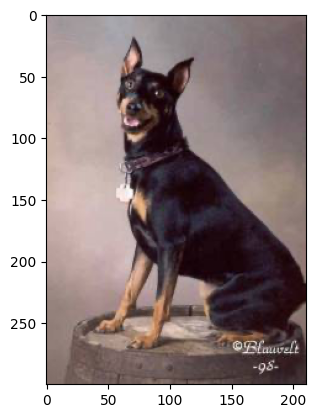

In [ ]:
path = np.random.choice(dataset_paths)
img = plt.imread(path)
plt.imshow(img)

이제 일부 매개변수를 정의합니다. 이 매개변수에는 크기 조정을 위한 스케일, 입력 및 출력 패치 크기, 출력 패치에 추가해야 하는 패딩 양 및 패치 추출에 사용할 스트라이드와 같은 값들이 포함됩니다.






In [ ]:
SCALE = 2.0
INPUT_DIM = 33
LABEL_SIZE = 21
PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)
STRIDE = 14

이제 입력 이미지를 읽고 저해상도 버전을 생성하고, 이 저해상도 이미지와 원본 이미지에서 슬라이딩 창을 이용하여 훈련용 패치를 생성하여 데이터셋을 구축해 보겠습니다.
이 패치들을 디스크에 저장하고 나중에 배치로 불러오는 훈련 데이터 생성기를 만들겠습니다.

In [ ]:
%%bash

mkdir -p data
mkdir -p training

In [ ]:
for image_path in tqdm(dataset_paths):
    filename = pathlib.Path(image_path).stem
    image = load_img(image_path)
    image = img_to_array(image)
    image = image.astype(np.uint8)
    image = tight_crop_image(image, SCALE)
    scaled = downsize_upsize_image(image, SCALE)

    height, width = image.shape[:2]

    for y in range(0, height - INPUT_DIM + 1, STRIDE):
        for x in range(0, width - INPUT_DIM + 1, STRIDE):
            crop = crop_input(scaled, x, y)
            target = crop_output(image, x, y)
            np.save(f'data/{filename}_{x}_{y}_input.np', crop)
            np.save(f'data/{filename}_{x}_{y}_output.np', target)



100%|██████████| 1000/1000 [05:05<00:00,  3.28it/s]


이전 단계에서 우리는 모든 패치를 메모리에 저장할 수 없기 때문에 디스크에 저장했습니다. 이제는 배치로 훈련 중에 패치와 해당 라벨을 로드하여 네트워크에 공급하는 데이터셋 로더가 필요합니다. 이를 `PatchesDataset` 클래스를 사용하여 수행합니다. (제너레이터에 대해 더 알아보려면 이 예제를 참조하세요. - [링크](https://dzlab.github.io/dltips/en/keras/data-generator/)).

In [ ]:
class PatchesDataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size, *args, **kwargs):
        self.batch_size = batch_size
        self.input = [*glob('data/*_input.np.npy')]
        self.output = [*glob('data/*_output.np.npy')]
        self.input.sort()
        self.output.sort()
        self.total_data = len(self.input)

    def __len__(self):
        # returns the number of batches
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        # returns one batch
        indices = self.random_indices()
        input = np.array([np.load(self.input[idx]) for idx in indices])
        output = np.array([np.load(self.output[idx]) for idx in indices])
        return input, output

    def random_indices(self):
        return np.random.choice(list(range(self.total_data)), self.batch_size, p=np.ones(self.total_data)/self.total_data)


GPU 메모리에 사용 가능한 양에 따라 배치 크기를 정의하고 데이터셋 생성기의 인스턴스를 만듭니다.






In [ ]:
BATCH_SIZE = 1024
train_ds = PatchesDataset(BATCH_SIZE)
len(train_ds)

616

트레이닝 배치의 shape를 확인할 수 있습니다.







In [ ]:
input, output = train_ds[0]
input.shape, output.shape

((1024, 33, 33, 3), (1024, 21, 21, 3))

## 모델

아래의 헬퍼 함수는 SRCNN 모델의 인스턴스를 생성하기 위한 함수입니다. SRCNN 모델의 아키텍처는 매우 간단합니다. 입력을 축소하고 이미지 특징을 추출하기 위한 단 하나의 컨볼루션 레이어와 출력 이미지를 생성하기 위한 컨볼루션 레이어 하나만을 갖습니다.

In [ ]:
def create_model(height, width, depth):
    input = Input(shape=(height, width, depth))
    x = Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='he_normal')(input)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    output = Conv2D(filters=depth, kernel_size=(5, 5), kernel_initializer='he_normal')(x)
    return Model(input, output)

네트워크를 훈련하기 위해, 학습률 감쇠를 가진 `Adam`을 옵티마이저로 사용할 것입니다. 또한, 우리가 해결하려는 문제는 회귀 문제입니다(고해상도 픽셀을 예측하고자 함). 따라서, 손실 함수로 `MSE`를 선택합니다. 이것은 모델이 저해상도에서 고해상도로 patch를 올바르게 매핑하는 필터를 학습하도록 만들 것입니다.

In [ ]:
EPOCHS = 12
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 / EPOCHS)
model = create_model(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss='mse', optimizer=optimizer)

모델이 작지만 충분한 시간 동안 학습하면 놀라운 결과를 얻을 수 있습니다. 12 epochs 동안 모델을 학습할 것입니다.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 33, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 64)        15616     
                                                                 
 re_lu (ReLU)                (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 re_lu_1 (ReLU)              (None, 25, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 3)         2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable p

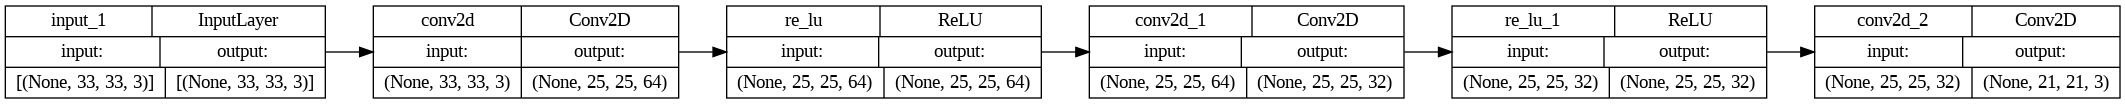

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, rankdir='LR')

이번에는 모델 가중치를 저장하기 위한 콜백(callback) 함수를 만들어 보겠습니다.

In [ ]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

이제 모델을 학습할 수 있습니다.

In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/12
888/888 [==============================] - ETA: 0s - loss: 258.0937
Epoch 00001: saving model to training/cp.ckpt
888/888 [==============================] - 1735s 2s/step - loss: 258.0937
Epoch 2/12
888/888 [==============================] - ETA: 0s - loss: 105.9775
Epoch 00002: saving model to training/cp.ckpt
888/888 [==============================] - 1428s 2s/step - loss: 105.9775
Epoch 3/12
888/888 [==============================] - ETA: 0s - loss: 102.4195
Epoch 00003: saving model to training/cp.ckpt
888/888 [==============================] - 1364s 2s/step - loss: 102.4195
Epoch 4/12
888/888 [==============================] - ETA: 0s - loss: 98.4859
Epoch 00004: saving model to training/cp.ckpt
888/888 [==============================] - 1347s 2s/step - loss: 98.4859
Epoch 5/12
888/888 [==============================] - ETA: 0s - loss: 97.5308
Epoch 00005: saving model to training/cp.ckpt
888/888 [==============================] - 1352s 2s/step - loss: 97.5308
Epoch 6/1

super_resolution 폴더가 구글 드라이브에 있는지 확인하십시오

In [ ]:
%%bash

mkdir -p /content/drive/MyDrive/super_resolution
cp -r training/* /content/drive/MyDrive/super_resolution

모델을 저장하고 불러옵니다

In [ ]:
path = '/content/drive/MyDrive/super_resolution/model.h5'
model.save(path)
new_model = tf.keras.models.load_model(path)

## 평가

랜덤 이미지를 선택하여 저해상도 이미지로 변환한 후 SRCNN 모델에 전달할 수 있습니다. 이를 위해 먼저 데이터셋에서 랜덤 이미지를 선택합니다. 다음으로, rescale_img 함수를 사용하여 이미지를 저해상도로 변환합니다. 이 함수는 이미지를 먼저 줄이고 다시 확대하여 저해상도 이미지를 생성합니다. 이 과정에서는 이미지의 세부 정보가 유실됩니다. 이 저해상도 이미지를 SRCNN 모델에 전달하여 고해상도 이미지를 생성할 수 있습니다.

In [ ]:
path = np.random.choice(dataset_paths)
image = load_img(path)
image = img_to_array(image)
image = image.astype(np.uint8)
image = tight_crop_image(image, SCALE)
scaled = downsize_upsize_image(image, SCALE)

다음으로, 출력 패치를 넣을 장소가 필요합니다. 이 장소는 최종 이미지를 생성하기 위해 출력 패치를 모아놓을 것입니다.

In [ ]:
output = np.zeros(scaled.shape)
height, width = output.shape[:2]

입력 이미지에서 패치를 추출하고, 훈련된 모델을 통해 고해상도 패치를 생성한 후, 이 패치를 이전 placeholder의 올바른 위치에 놓습니다. 입력 이미지의 모든 패치를 처리한 후 최종 출력 이미지가 생성됩니다.

In [ ]:
for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
    for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
        crop = crop_input(scaled, x, y)
        image_batch = np.expand_dims(crop, axis=0)
        prediction = model.predict(image_batch)
        new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
        prediction = prediction.reshape(new_shape)
        output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
        output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
        output[output_y_slice, output_x_slice] = prediction

1/1 [==============================] - 0s 25ms/step


이제 우리는 저해상도 이미지와 더 높은 해상도의 결과 이미지를 나란히 표시할 수 있습니다.

(-0.5, 499.5, 279.5, -0.5)

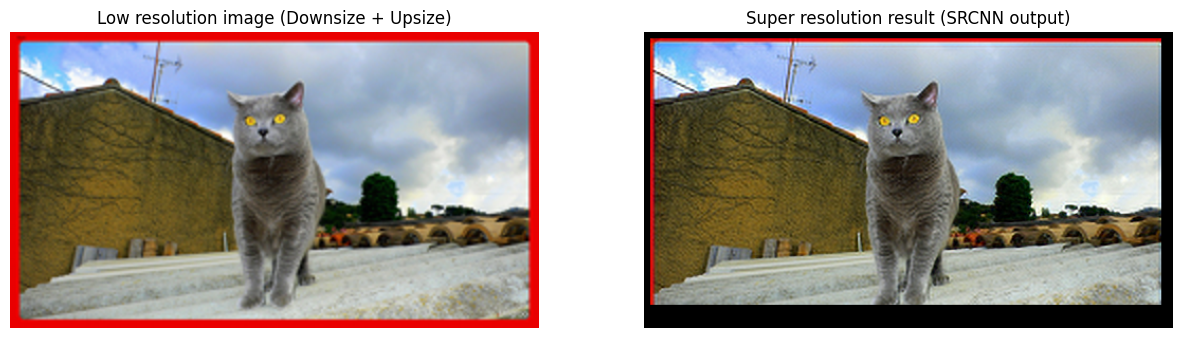

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(15, 8))
axis[0].imshow(np.array(scaled,np.int32))
axis[0].set_title('Low resolution image (Downsize + Upsize)')
axis[0].axis('off')

axis[1].imshow(np.array(output,np.int32))
axis[1].set_title('Super resolution result (SRCNN output)')
axis[1].axis('off')

결과는 매우 인상적입니다. 우리가 훈련시킨 작은 모델에 비해 매우 성능이 좋았습니다. 입력 이미지의 해상도를 상당히 향상시킬 수 있었습니다.